In [1]:
%load_ext autoreload
%autoreload 2

import lamp
from lamp import ILAMP
from lamp import RBFInv
import data
import numpy as np
from sklearn import manifold
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt

# Fashion MNIST dataset

In [5]:
X_train, y_train = data.LoadFashionMNIST('train', 'data/fm/orig/')
new_idx = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[new_idx], y_train[new_idx]

projection_size = 2000
X_proj = np.copy(X_train[:projection_size])
X_proj = np.reshape(X_proj, (X_proj.shape[0], X_proj.shape[1]*X_proj.shape[2]))

start = time.time()
print("LAMP projecting Fashion MNIST dataset...")
Xp_lamp = lamp.lamp2d(X_proj, 150, 10.0)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
Xp_lamp = scaler.fit_transform(Xp_lamp)
print("\tFinished projecting...", time.time() - start)

# Uses t-SNE to project projection_size points from the dataset
start = time.time()
print("t-SNE projecting Fashion MNIST dataset...")
tsne = manifold.TSNE(n_components=2, perplexity=20.0)
Xp_tsne = tsne.fit_transform(X_proj)
Xp_tsne = scaler.fit_transform(Xp_tsne)
# Xp_tsne = (Xp_tsne - Xp_tsne.min(axis=0))/(Xp_tsne.max(axis=0) - Xp_tsne.min(axis=0))
print("\tProjection finished: ", time.time() - start)

LAMP projecting Fashion MNIST dataset...
	Finished projecting... 27.77294635772705
t-SNE projecting Fashion MNIST dataset...
	Projection finished:  18.322688817977905


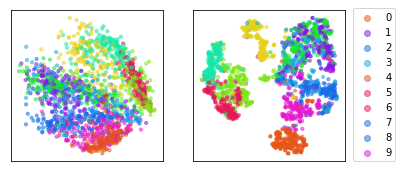

In [6]:
# COLORS are the rgb counterparts of Grid.CMAP_SYN
COLORS = np.array([[0.09, 0.414, 0.9, 0.5],
                   [0.9, 0.333, 0.09, 0.5],
                   [0.09, 0.9, 0.171, 0.5],
                   [0.9, 0.09, 0.819, 0.5],
                   [0.495, 0.09, 0.9, 0.5],
                   [0.495, 0.9, 0.09, 0.5],
                   [0.09, 0.657, 0.9, 0.5],
                   [0.9, 0.09, 0.333, 0.5],
                   [0.9, 0.819, 0.09, 0.5],
                   [0.09, 0.9, 0.657, 0.5]])

y_proj = y_train[:projection_size]
colors = [COLORS[i] for i in y_proj]
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
leg_colors = COLORS[:len(labels)]
plt.title("Projections")

ax = plt.subplot(121)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.scatter(Xp_lamp[:, 0], Xp_lamp[:, 1], color=colors, s=10.0)

ax = plt.subplot(122)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.scatter(Xp_tsne[:, 0], Xp_tsne[:, 1], color=colors, s=10.0)


handles = []
for c in colors:
    handles.append(plt.scatter([], [], color=c))
ax.legend(handles, labels, loc="lower left", borderaxespad=0.0, bbox_to_anchor=(1.05, 0))

## iLAMP

Initializing Lamp (kdtree)
	time:  0.0017292499542236328
Back projecting
	time:  0.07133173942565918


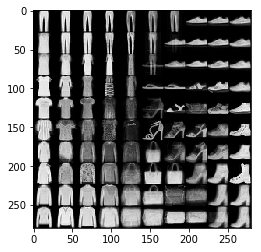

In [7]:
def make_img_grid(syn_imgs, N):
    img_grid = np.zeros((N*28, N*28))
    for row in range(N):
        for col in range(N):
            img_grid[row*28:row*28 + 28, (9 - col)*28:(9 - col)*28 + 28] = syn_imgs[N*row + col].reshape((28, 28))
    return img_grid
    

divs = np.linspace(0.0, 1.0, 11)
coords = (divs[:-1] + divs[1:])*0.5
xx, yy = np.meshgrid(coords, coords)
p_coords = np.dstack((xx, yy))
p_coords = np.vstack(p_coords)

N = 10

print("Initializing Lamp (kdtree)")
s = time.time()
ilamp = ILAMP()
ilamp.fit(X_proj, Xp_tsne, n_neighbors=20)
print("\ttime: ", time.time() - s)


print("Back projecting")
s = time.time()
syn_samples_ilamp = ilamp.transform(p_coords)
print("\ttime: ", time.time() - s)

plt.imshow(make_img_grid(syn_samples_ilamp, N), cmap="gray")

## RBF Inverse

Back project a $2D$ point $p$ by interpolating among $nD$ data.


Three modes:
1. 'rols': Use a set of control points obtained by regularized orthogonal least squares (rols).
2. 'cluster': Control points obtained by rols are cluster centers. Use all points inside the cluster which the center is closer to p.
3. 'neighbors': Use k-nearests 2D neighbors of p.

Three kernels:
1. multiquadrics
2. inverse multiquadrics
3. gaussian

### Multiquadrics kernel

$$ \phi = \sqrt{c + \epsilon r^2} $$

In [8]:
def multi_quadrics(r):
    return np.sqrt(c + eps*(r**2))

#print("Initializing RBFInv")
#s = time.time()
c = 0.0
eps = 1.0
irbf_mq0 = RBFInv()
irbf_mq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=multi_quadrics, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
# print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
invmq0 = irbf_mq0.transform(p_coords)
#print("\ttime: ", time.time() - s)

c = 0.0
eps=100.0
irbf_mq1 = RBFInv()
irbf_mq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=multi_quadrics, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invmq1 = irbf_mq1.transform(p_coords)

c = 0.0
eps=1000.0
irbf_mq2 = RBFInv()
irbf_mq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=multi_quadrics, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invmq2 = irbf_mq2.transform(p_coords)

c = 0.0
eps=10000.0
irbf_mq3 = RBFInv()
irbf_mq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=multi_quadrics, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invmq3 = irbf_mq3.transform(p_coords)

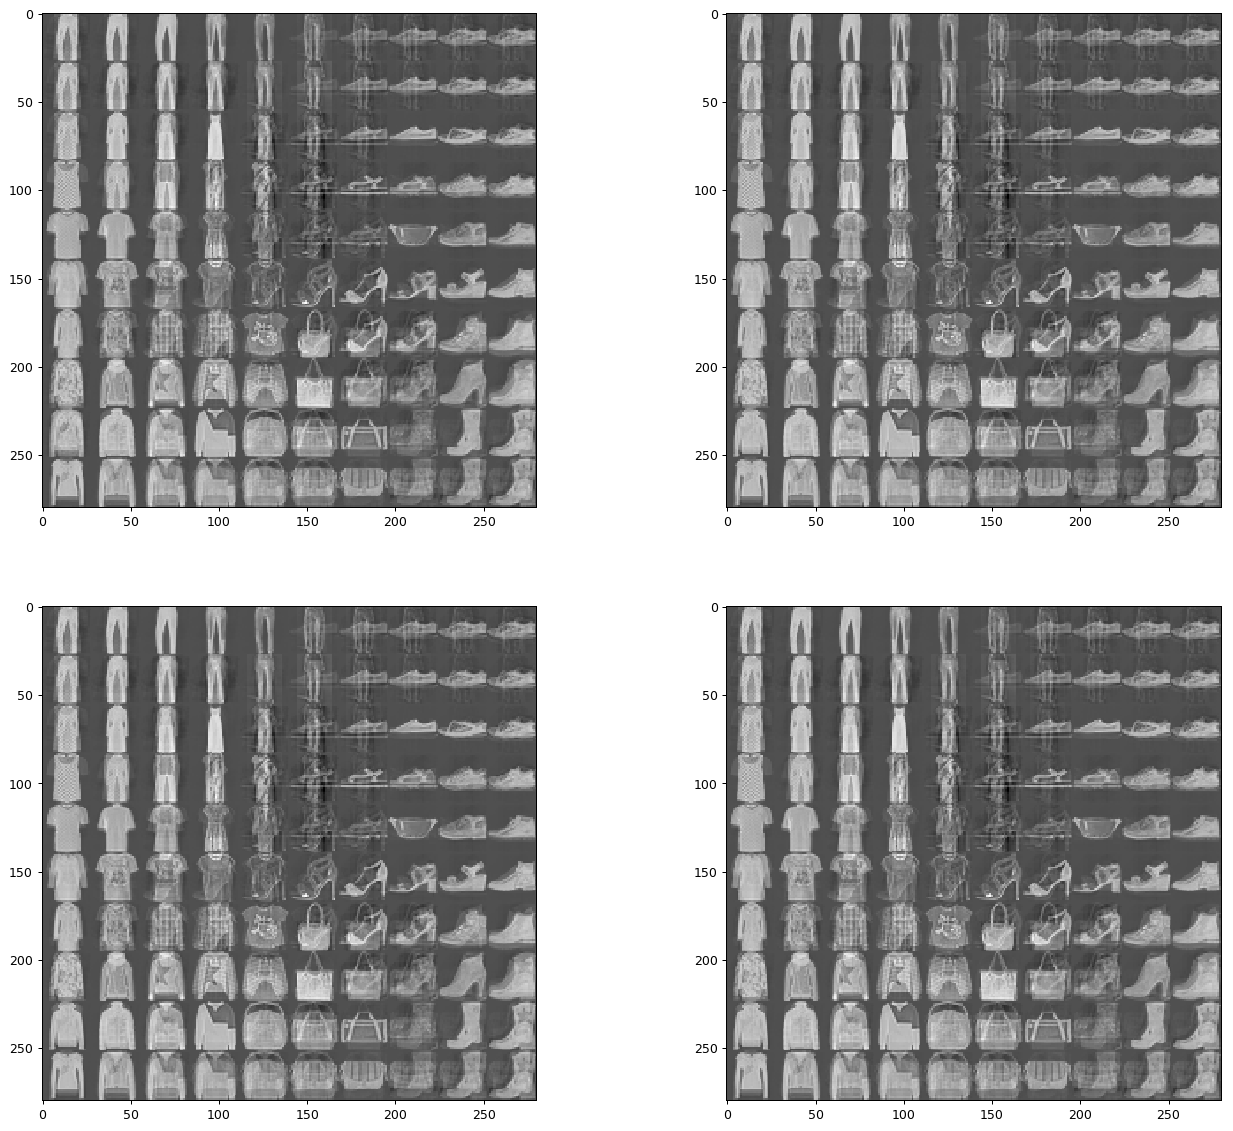

In [9]:
def plot_four(inv0, inv1, inv2, inv3):
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 16), dpi=90)
    ax[0, 0].imshow(make_img_grid(inv0, N), cmap='gray')
    ax[0, 1].imshow(make_img_grid(inv1, N), cmap='gray')
    ax[1, 0].imshow(make_img_grid(inv2, N), cmap='gray')
    ax[1, 1].imshow(make_img_grid(inv3, N), cmap='gray')
    
plot_four(invmq0, invmq1, invmq2, invmq3)

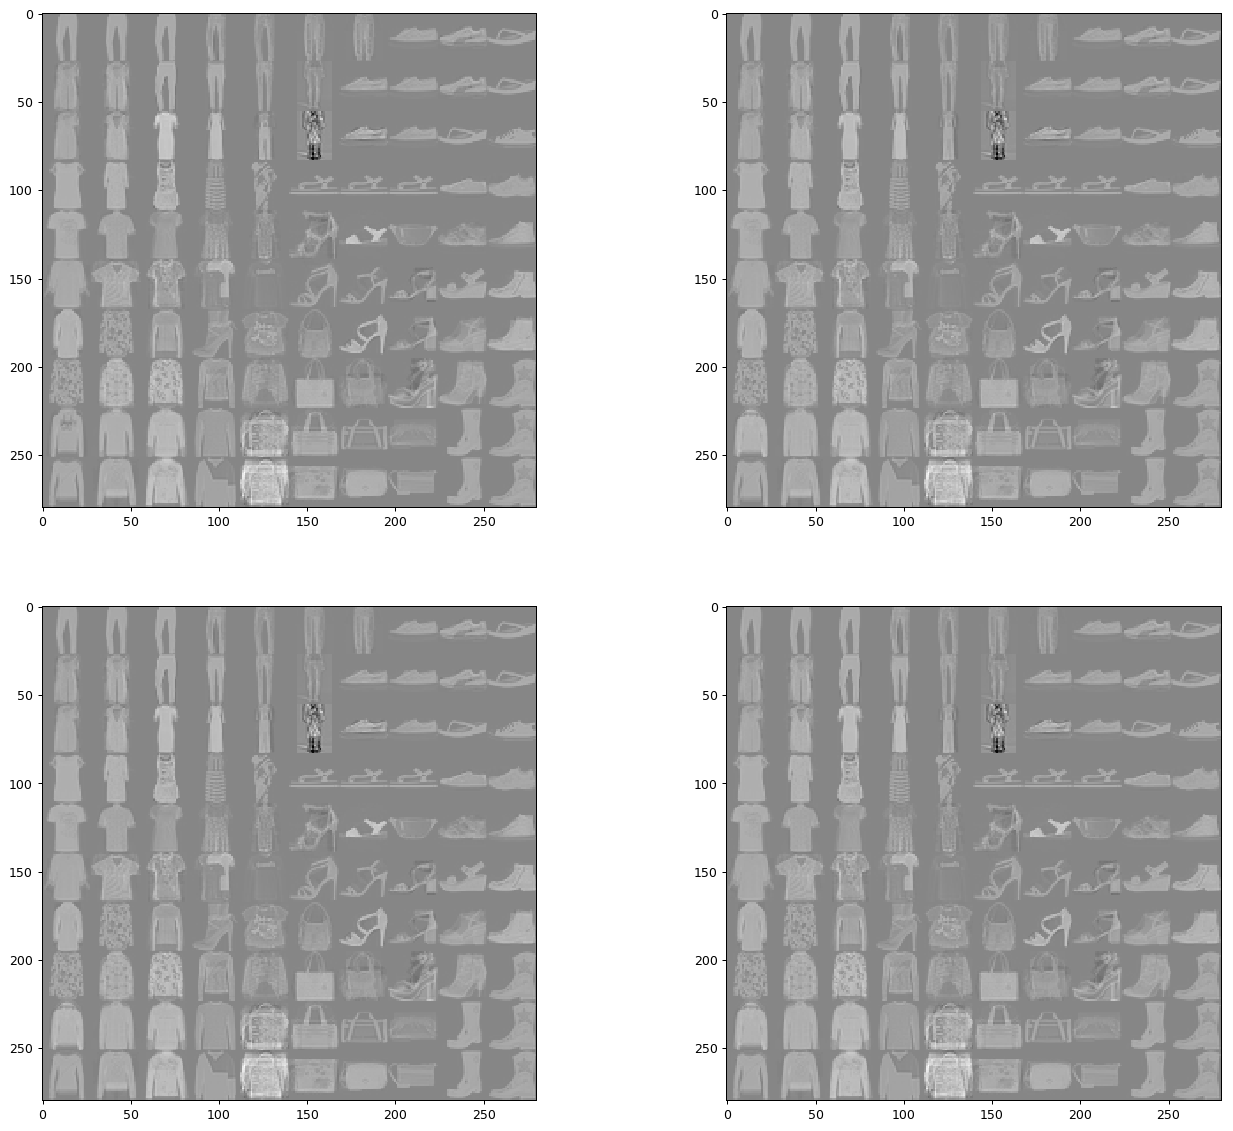

In [13]:
c = 0.0
eps = 1.0
#print("Initializing RBFInv")
#s = time.time()
irbfc_mq0 = RBFInv()
irbfc_mq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_cmq0 = irbfc_mq0.transform(p_coords)

c = 0.0
eps = 100.0
irbfc_mq1 = RBFInv()
irbfc_mq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cmq1 = irbfc_mq1.transform(p_coords)

c = 0.0
eps = 1000.0
irbfc_mq2 = RBFInv()
irbfc_mq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cmq2 = irbfc_mq2.transform(p_coords)

c = 0.0
eps = 10000.0
irbfc_mq3 = RBFInv()
irbfc_mq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=multi_quadrics, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cmq3 = irbfc_mq3.transform(p_coords)

#print("\ttime: ", time.time() - s)
plot_four(inv_cmq0, inv_cmq1, inv_cmq2, inv_cmq3)

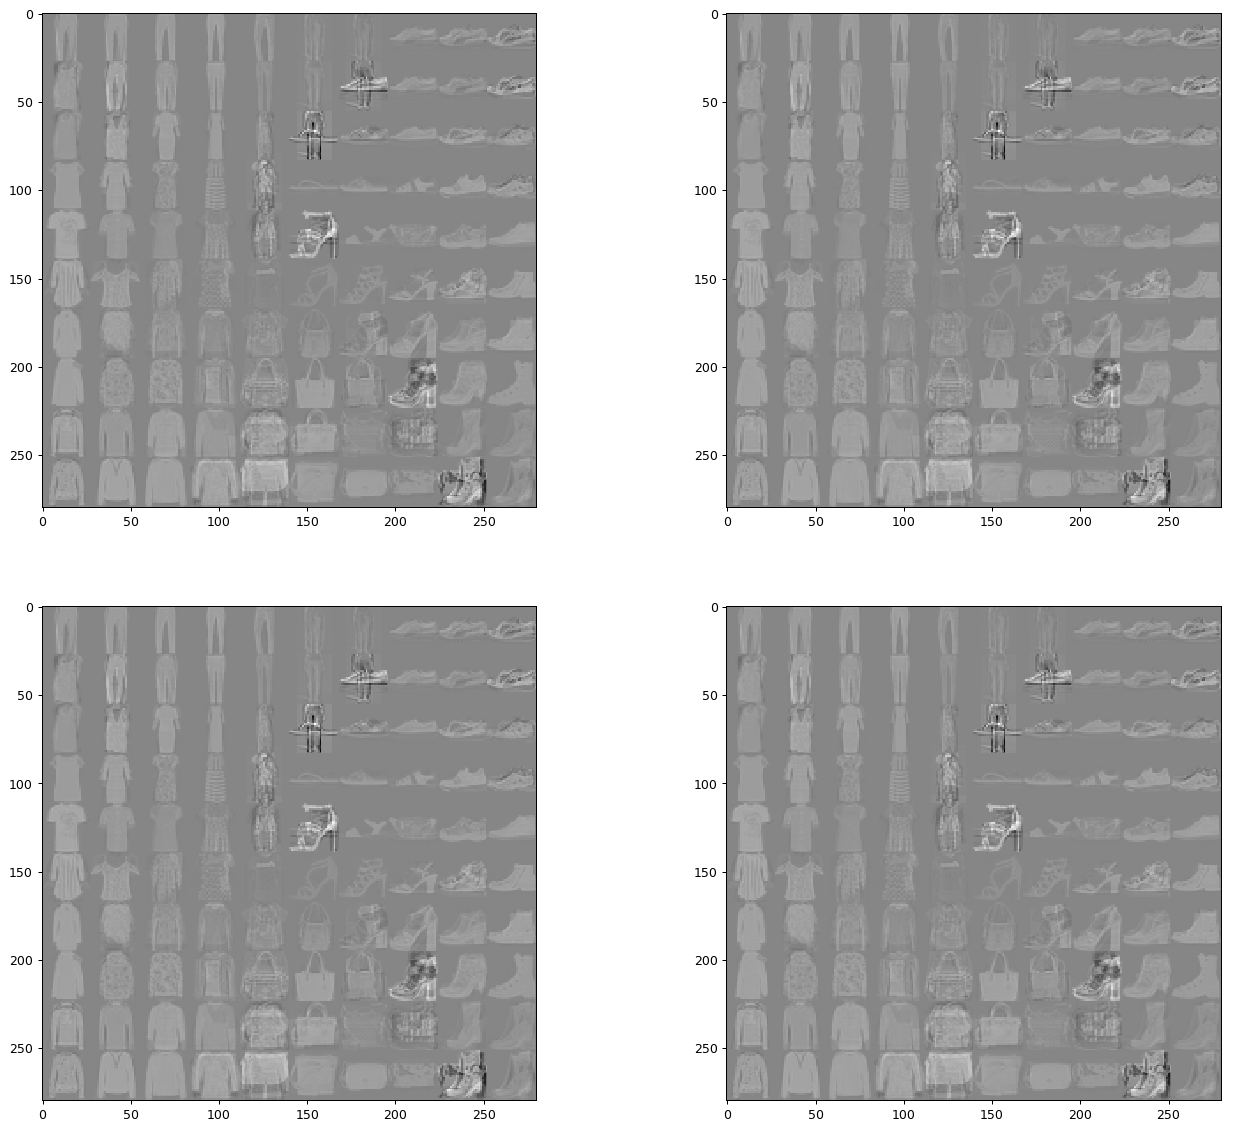

In [14]:
#print("Initializing RBFInv")
#s = time.time()
c = 0.0
eps = 1.0
irbfn_mq0 = RBFInv()
irbfn_mq0.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_nmq0 = irbfn_mq0.transform(p_coords)

c = 0.0
eps = 100.0
irbfn_mq1 = RBFInv()
irbfn_mq1.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
inv_nmq1 = irbfn_mq1.transform(p_coords)

c = 0.0
eps = 1000.0
irbfn_mq2 = RBFInv()
irbfn_mq2.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
inv_nmq2 = irbfn_mq2.transform(p_coords)

c = 0.0
eps = 10000.0
irbfn_mq3 = RBFInv()
irbfn_mq3.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=multi_quadrics, normalize_c=True, normalize_d=True)
inv_nmq3 = irbfn_mq3.transform(p_coords)


plot_four(inv_nmq0, inv_nmq1, inv_nmq2, inv_nmq3)
#print("\ttime: ", time.time() - s)
#plt.imshow(make_img_grid(syn_samples_irbf3, N), cmap='gray')

### Gaussian kernel

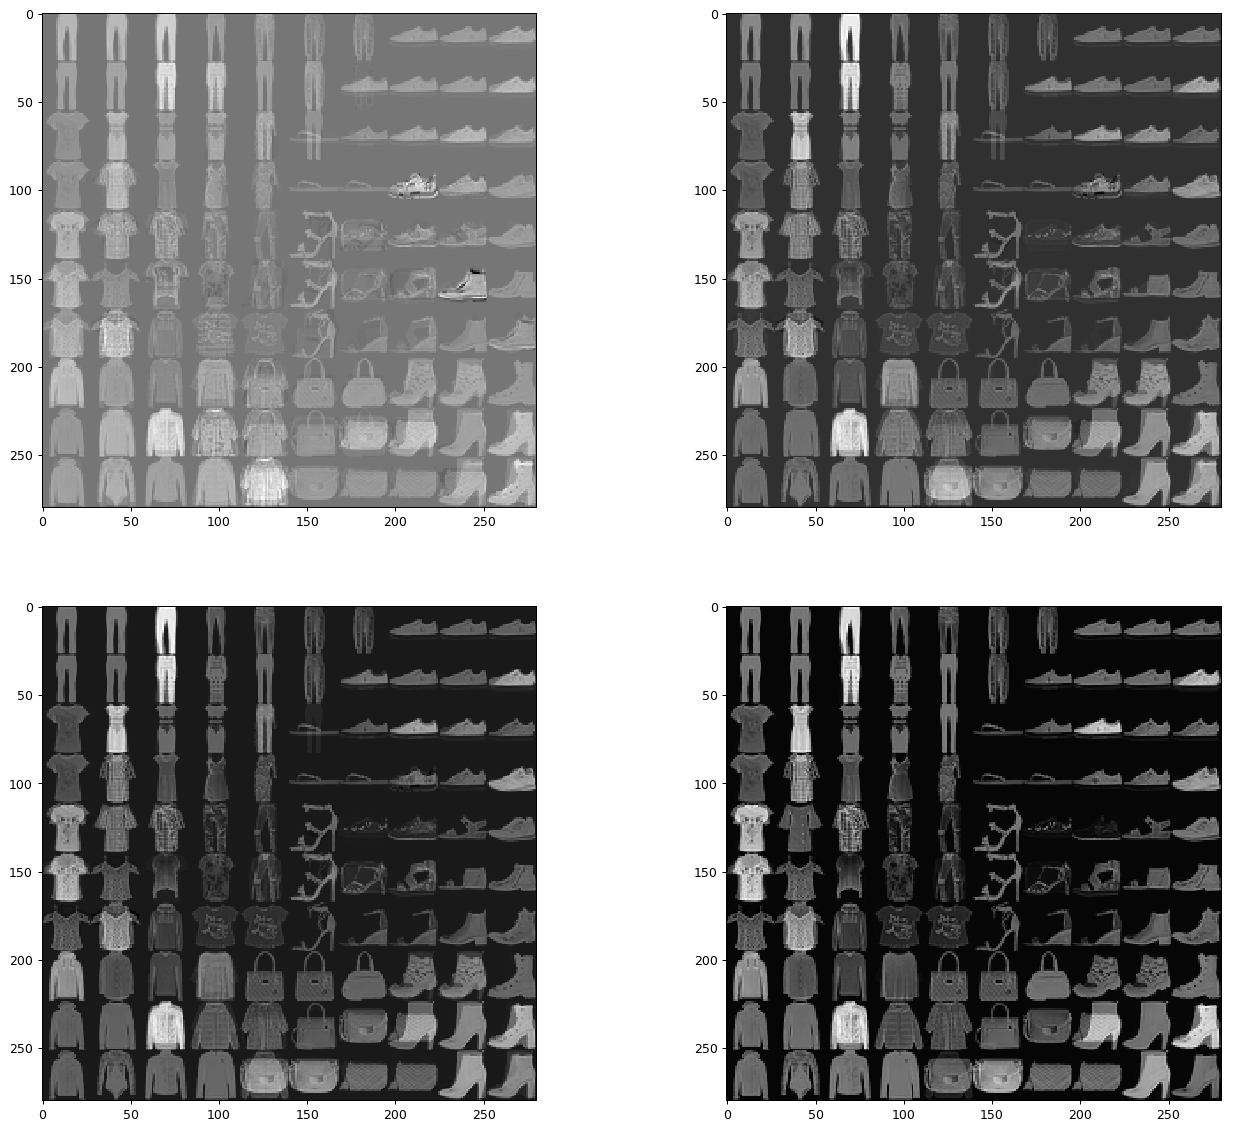

In [15]:
#def gk_4000(r):
#    eps = 4000
#    return np.exp(-(eps*(r**2.0)))

def gaussian(r):
    return np.exp(-(eps*(r**2.0)))

eps = 1000
#print("Initializing RBFInv")
#s = time.time()
irbf_gk0 = RBFInv()
irbf_gk0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_gk0 = irbf_gk0.transform(p_coords)
#print("\ttime: ", time.time() - s)

eps = 5000
irbf_gk1 = RBFInv()
irbf_gk1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
inv_gk1 = irbf_gk1.transform(p_coords)

eps = 10000
irbf_gk2 = RBFInv()
irbf_gk2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
inv_gk2 = irbf_gk2.transform(p_coords)

eps = 50000
irbf_gk3 = RBFInv()
irbf_gk3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=gaussian, normalize_c=True, normalize_d=True)
inv_gk3 = irbf_gk3.transform(p_coords)


#plt.imshow(make_img_grid(syn_samples_irbf4, N), cmap='gray')
plot_four(inv_gk0, inv_gk1, inv_gk2, inv_gk3)

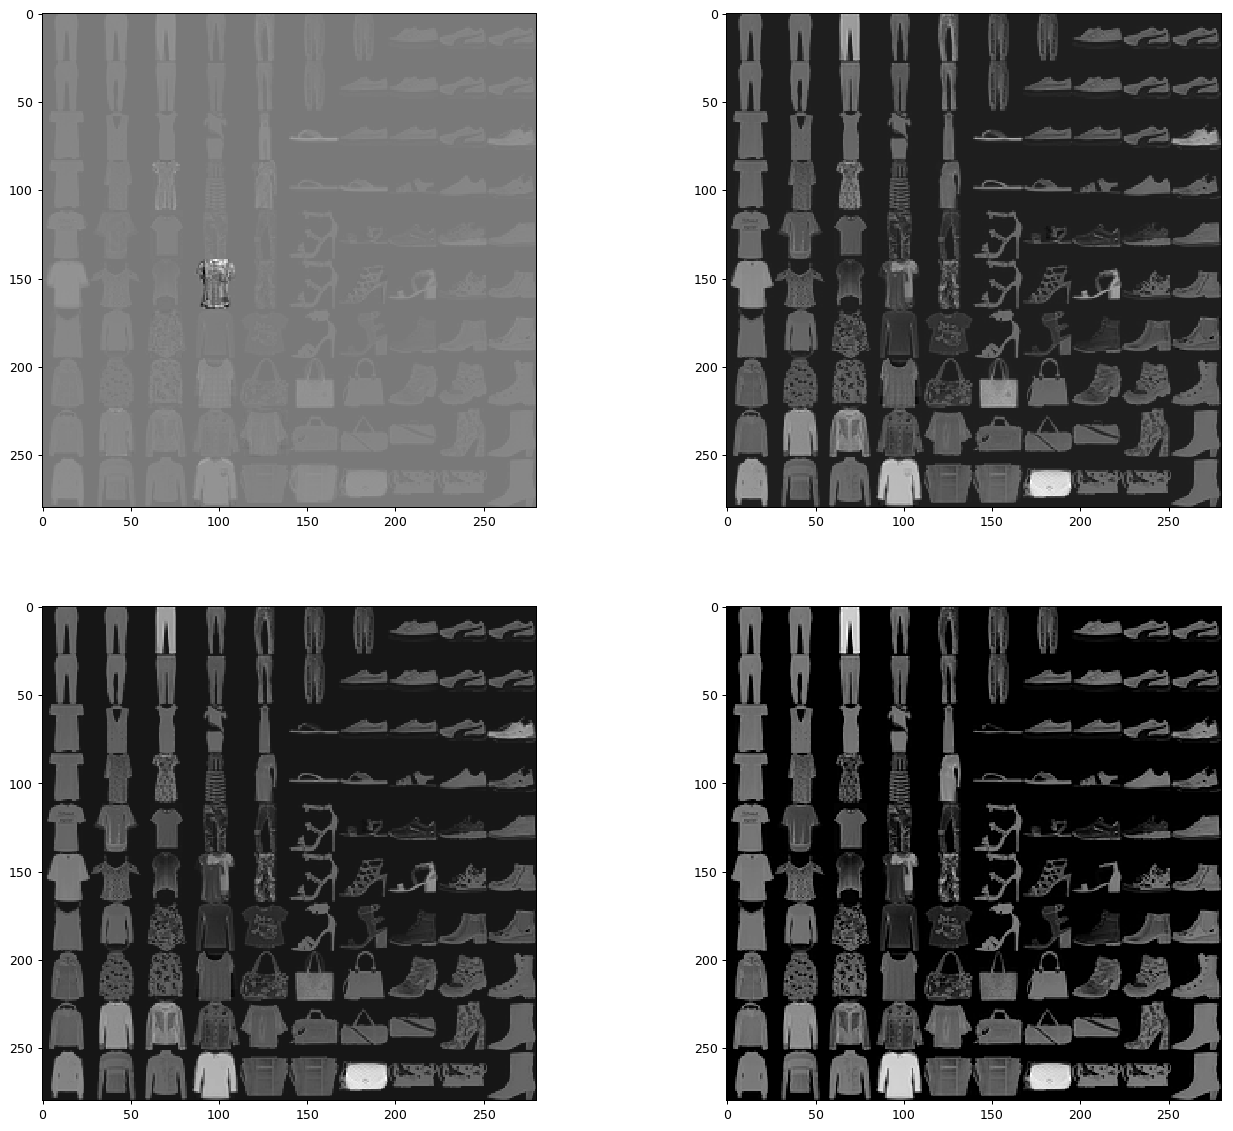

In [16]:
#print("Initializing RBFInv")
#s = time.time()
eps = 1000
irbfc_gk0 = RBFInv()
irbfc_gk0.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
invc_gk0 = irbfc_gk0.transform(p_coords)
#print("\ttime: ", time.time() - s)


eps = 5000
irbfc_gk1 = RBFInv()
irbfc_gk1.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
invc_gk1 = irbfc_gk1.transform(p_coords)

eps = 10000
irbfc_gk2 = RBFInv()
irbfc_gk2.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
invc_gk2 = irbfc_gk2.transform(p_coords)

eps = 50000
irbfc_gk3 = RBFInv()
irbfc_gk3.fit(X_proj, Xp_tsne, num_ctrl=120, mode='cluster', kernel=gaussian, normalize_c=True, normalize_d=True)
invc_gk3 = irbfc_gk3.transform(p_coords)

plot_four(invc_gk0, invc_gk1, invc_gk2, invc_gk3)
#plt.imshow(make_img_grid(syn_samples_irbf5, N), cmap='gray')

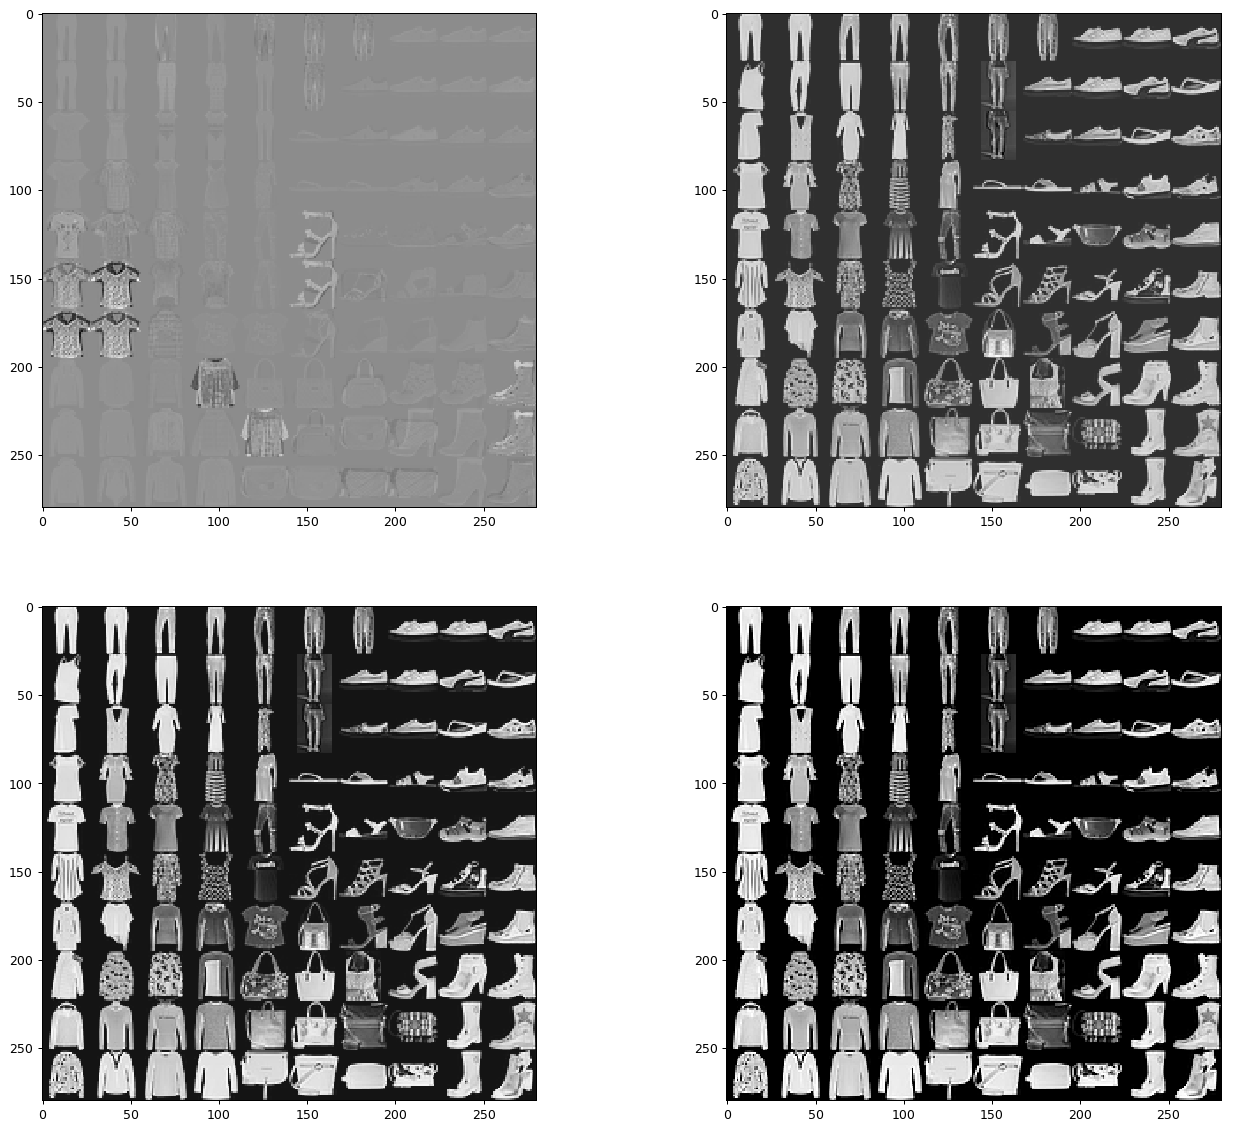

In [17]:
eps = 100000
#print("Initializing RBFInv")
#s = time.time()
irbfn_gk0 = RBFInv()
irbfn_gk0.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
#print("\ttime: ", time.time() - s)
#print("Back projecting")
#s = time.time()
invn_gk0 = irbf_gk0.transform(p_coords)


eps = 500000
irbfn_gk1 = RBFInv()
irbfn_gk1.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
invn_gk1 = irbfn_gk1.transform(p_coords)

eps = 1000000
irbfn_gk2 = RBFInv()
irbfn_gk2.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
invn_gk2 = irbfn_gk2.transform(p_coords)


eps = 5000000
irbfn_gk3 = RBFInv()
irbfn_gk3.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=gaussian, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
invn_gk3 = irbfn_gk3.transform(p_coords)


plot_four(invn_gk0, invn_gk1, invn_gk2, invn_gk3)

### Inverse Multiquadrics

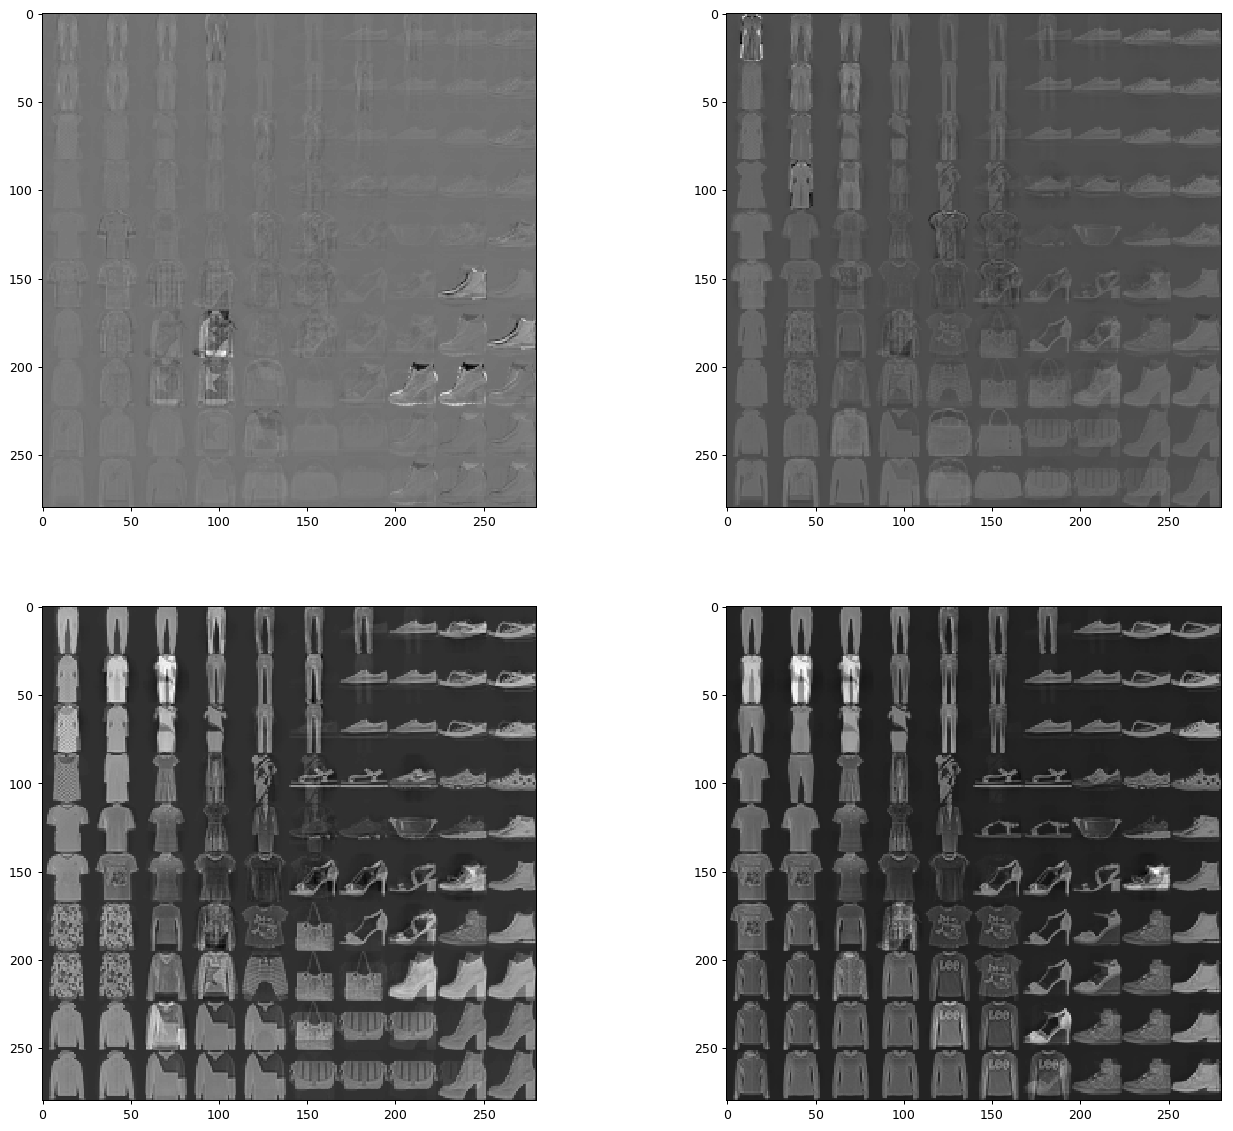

In [18]:
def inv_mq(r):
    return 1.0/np.sqrt(c + eps*(r**2))

c = 1.0
eps = 100.0
irbf_imq0 = RBFInv()
irbf_imq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
# print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
invimq0 = irbf_imq0.transform(p_coords)
#print("\ttime: ", time.time() - s)

c = 1.0
eps=1000.0
irbf_imq1 = RBFInv()
irbf_imq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invimq1 = irbf_imq1.transform(p_coords)

c = 1.0
eps=10000.0
irbf_imq2 = RBFInv()
irbf_imq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invimq2 = irbf_imq2.transform(p_coords)

c = 1.0
eps=100000.0
irbf_imq3 = RBFInv()
irbf_imq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='rols', kernel=inv_mq, normalize_c=True, normalize_d=True, 
         reg_coef=0.0)
invimq3 = irbf_imq3.transform(p_coords)

plot_four(invimq0, invimq1, invimq2, invimq3)

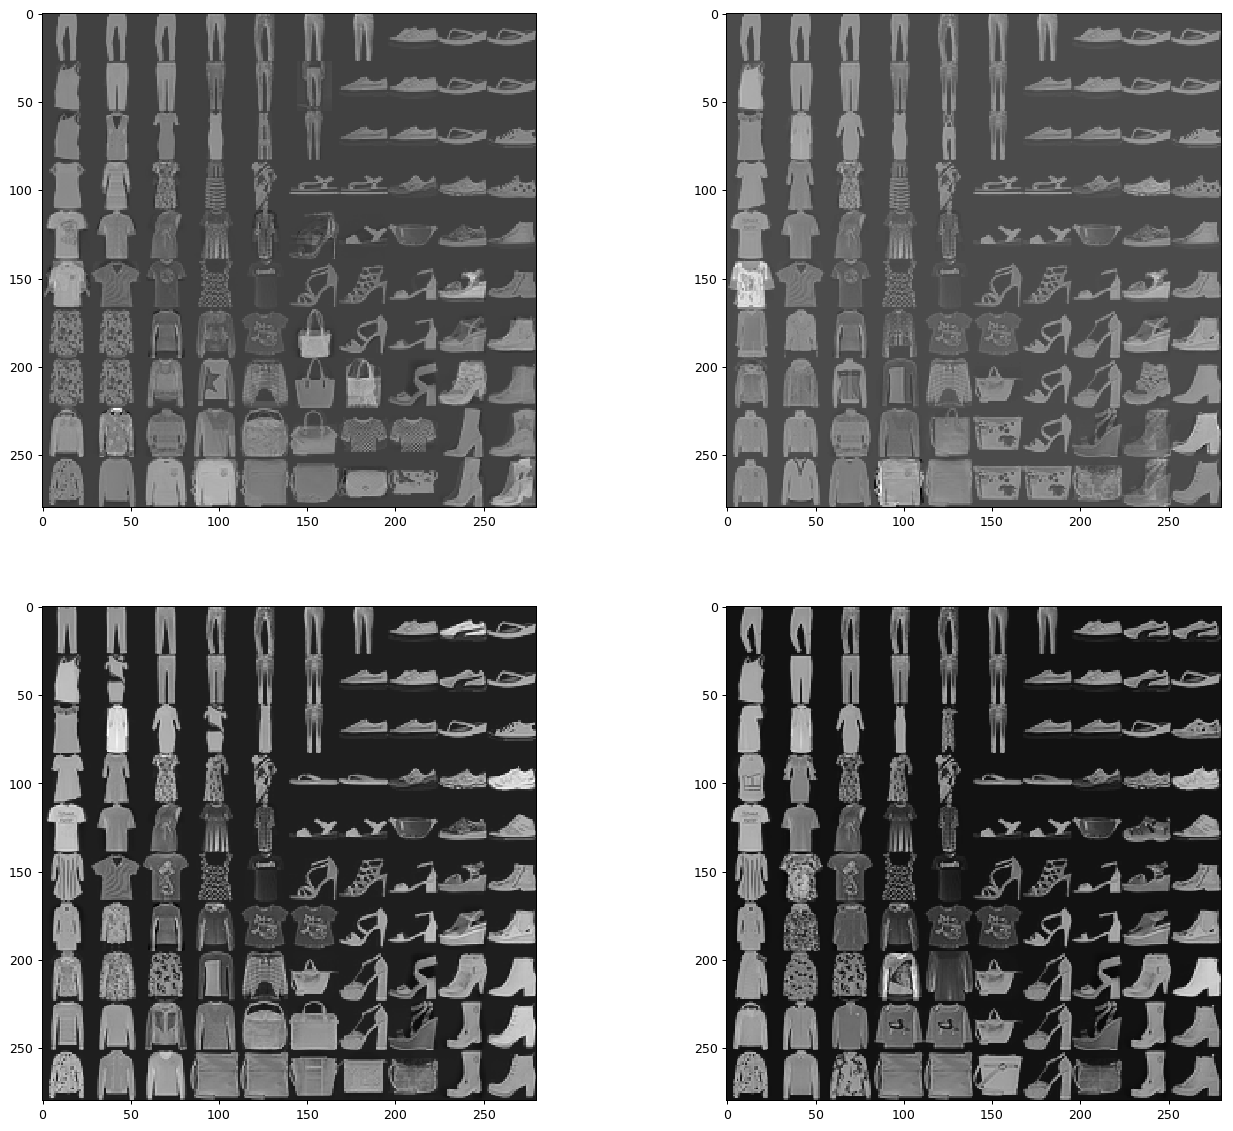

In [19]:
c = 1.0
eps = 10000.0
#print("Initializing RBFInv")
#s = time.time()
irbfc_imq0 = RBFInv()
irbfc_imq0.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_cimq0 = irbfc_imq0.transform(p_coords)

c = 1.0
eps = 100000.0
irbfc_imq1 = RBFInv()
irbfc_imq1.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cimq1 = irbfc_imq1.transform(p_coords)

c = 1.0
eps = 1000000.0
irbfc_imq2 = RBFInv()
irbfc_imq2.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cimq2 = irbfc_imq2.transform(p_coords)

c = 1.0
eps = 10000000.0
irbfc_imq3 = RBFInv()
irbfc_imq3.fit(X_proj, Xp_tsne, num_ctrl=100, mode='cluster', kernel=inv_mq, normalize_c=True, normalize_d=True,
          reg_coef=0.0)
inv_cimq3 = irbfc_imq3.transform(p_coords)

#print("\ttime: ", time.time() - s)
plot_four(inv_cimq0, inv_cimq1, inv_cimq2, inv_cimq3)

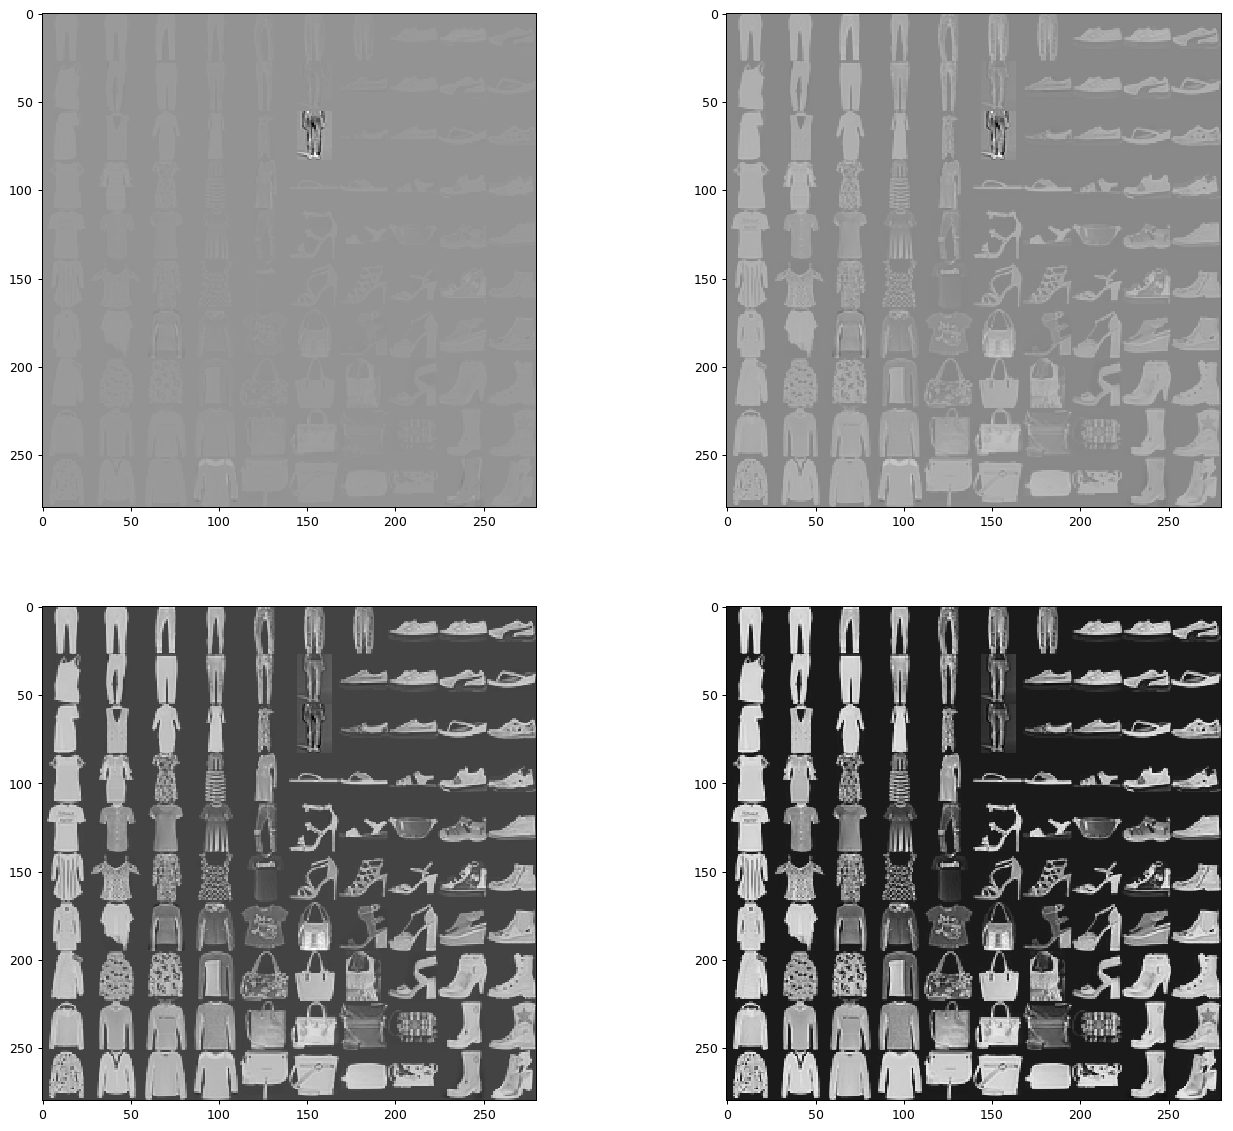

In [20]:
#print("Initializing RBFInv")
#s = time.time()
c = 1.0
eps = 10000.0
irbfn_imq0 = RBFInv()
irbfn_imq0.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
#print("\ttime: ", time.time() - s)

#print("Back projecting")
#s = time.time()
inv_nimq0 = irbfn_imq0.transform(p_coords)

c = 1.0
eps = 100000.0
irbfn_imq1 = RBFInv()
irbfn_imq1.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
inv_nimq1 = irbfn_imq1.transform(p_coords)

c = 1.0
eps = 1000000.0
irbfn_imq2 = RBFInv()
irbfn_imq2.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
inv_nimq2 = irbfn_imq2.transform(p_coords)

c = 1.0
eps = 10000000.0
irbfn_imq3 = RBFInv()
irbfn_imq3.fit(X_proj, Xp_tsne, num_ctrl=20, mode='neighbors', kernel=inv_mq, normalize_c=True, normalize_d=True)
inv_nimq3 = irbfn_imq3.transform(p_coords)


plot_four(inv_nimq0, inv_nimq1, inv_nimq2, inv_nimq3)